## Setup

In [1]:
import sys
sys.path.append('../')
del sys
%reload_ext autoreload
%autoreload 2

In [8]:
from modeling.pipeline import Pipeline
from modeling.nn import RegressionMLP, ClassificationMLP
import torch

## Data pipeline parameters

In [3]:
batch_size = 64
drop_last = False
test_proportion = 0.2
valid_proportion = 0.2
use_k_fold = False
k_k_fold = None

## Load the data

In [4]:
pipeline = Pipeline(use_k_fold=use_k_fold)
pipeline.process_data(batch_size=batch_size,
                      drop_last=drop_last,
                      test_proportion=test_proportion,
                      valid_proportion=valid_proportion,
                      k=k_k_fold)

Processing the modeling task...
Computing the annotated queries...
Initial length of queries: 0
Object loaded from ../results/../results/task_annotation/v2_0/task/queries_size10k_shuffle_articles1_queries1_seed0.pkl
Object loaded from ../results/../results/task_annotation/v2_1/task/queries_sizemax_shuffle_articles1_queries1_seed0.pkl
Object loaded from ../results/../results/task_annotation/v2_2/task/queries_sizemax_shuffle_articles1_queries1_seed0.pkl
Final length of queries: 61056
Done (elapsed time: 1s).

Computing the annotations...
Initial length of annotations: 0
Object loaded from ../results/task_annotation/v2_0/results/batch_00_complete.csv
   Correcting "n this article, Nevada and Ohio are discussed. The two American states..." to " The two American states..."
   Correcting "In this article, California and Oregon are discussed. The two neighboring states..." to " The two neighboring states..."
   Correcting "In this article, California and Oregon are discussed. The two West Coa

## Parameters

In [15]:
n_updates = 200
n_epochs = 3

## Metrics

In [6]:
scores_names = ['average_precision', 'precision_at_k']
is_regression = True

In [9]:
weight = torch.tensor([1, 100], dtype=torch.float)
loss = torch.nn.MSELoss() if is_regression else torch.nn.CrossEntropyLoss(weight=weight)

### BOW

In [9]:
input_dim, hidden_dim1, hidden_dim2 = 4310, 500, 10
dropout = 0
lr = 1e-5

if is_regression:
    net = RegressionMLP(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, dropout=dropout)
else:
    net = ClassificationMLP(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, dropout=dropout)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [10]:
from modeling.models import BOWModel

model = BOWModel(min_vocab_frequency=100, net=net, optimizer=optimizer, loss=loss, score=score)
pipeline.preview_data(model=model, include_valid=False)

Learning the vocabulary...



Input size: 4310


In [11]:
train_losses, train_scores, valid_losses, valid_scores = pipeline.train_model(model=model, 
                                                                              n_epochs=n_epochs, 
                                                                              n_updates=n_updates,
                                                                              is_regression=is_regression)

Training of the model...




Epoch 1/5: Validation Loss: 0.00446 Validation Score: 0.19883
--------------------------------------------------------------



Epoch 2/5: Validation Loss: 0.00440 Validation Score: 0.19992
--------------------------------------------------------------



Epoch 3/5: Validation Loss: 0.00440 Validation Score: 0.20053
--------------------------------------------------------------



Epoch 4/5: Validation Loss: 0.00439 Validation Score: 0.19852
--------------------------------------------------------------



Epoch 5/5: Validation Loss: 0.00439 Validation Score: 0.19720
--------------------------------------------------------------


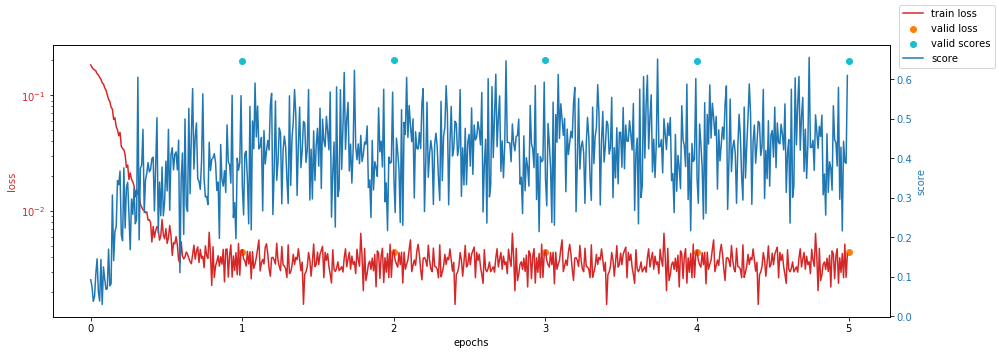

In [12]:
plot_metrics(train_losses, train_scores, valid_losses, valid_scores)

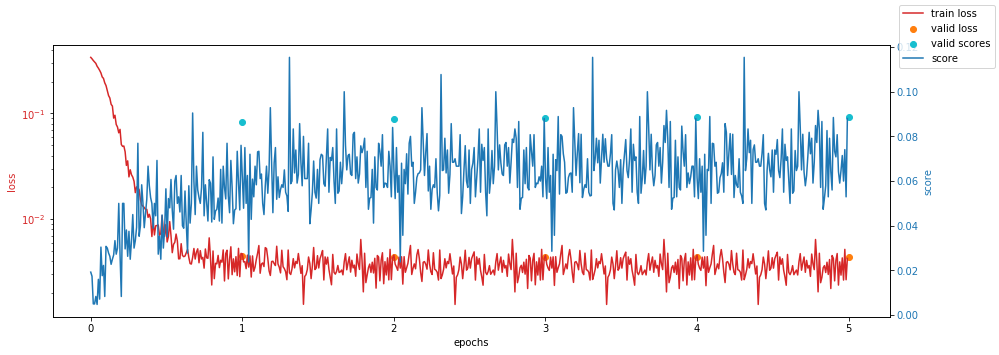

In [12]:
plot_metrics(train_losses, train_scores, valid_losses, valid_scores)

### Embedding

In [10]:
input_dim, hidden_dim1, hidden_dim2 = 600, 200, 10
dropout = 0
lr = 1e-5

if is_regression:
    net = RegressionMLP(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, dropout=dropout)
else:
    net = ClassificationMLP(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, dropout=dropout)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [11]:
from modeling.models import EmbeddingModel

model = EmbeddingModel(net=net, optimizer=optimizer, loss=loss, scores_names=scores_names)
pipeline.preview_data(model=model, include_valid=False)

Initializing the Word2Vec embedding...
Input dimension: 600


In [12]:
pipeline.train_model(model=model, 
                     n_epochs=n_epochs, 
                     n_updates=n_updates,
                     is_regression=is_regression)

Training of the model...




Epoch 1/2: Validation Loss: 0.00441 Validation Score: 0.00847
--------------------------------------------------------------



Epoch 2/2: Validation Loss: 0.00438 Validation Score: 0.01758
--------------------------------------------------------------


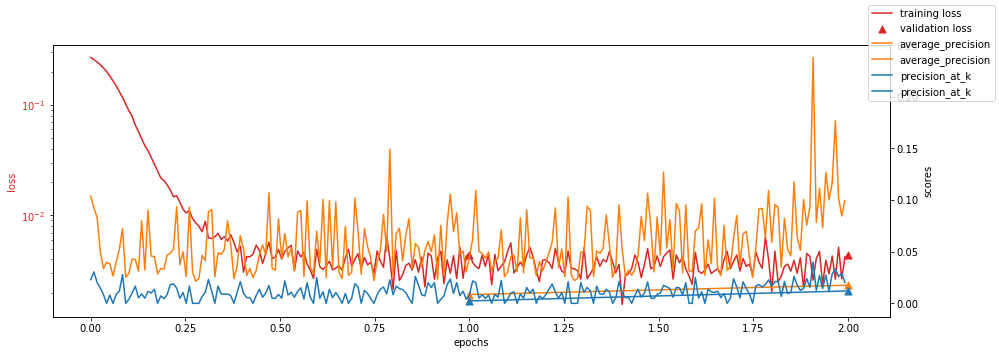

In [24]:
model.plot_metrics()

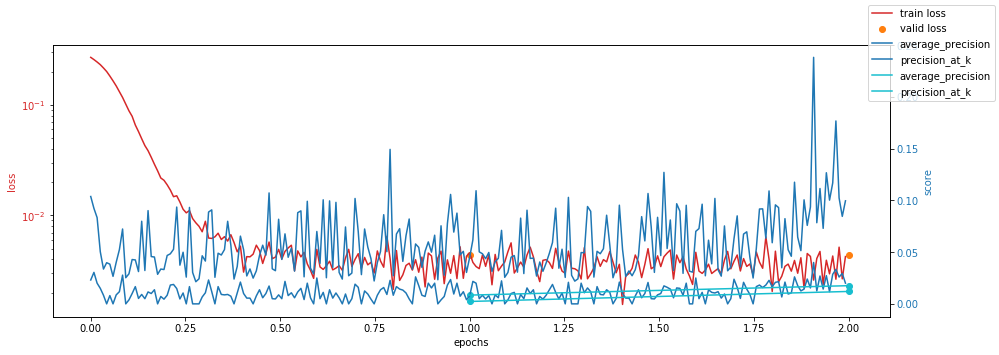

In [13]:
model.plot_metrics()

### Embedding Bis

In [25]:
input_dim, hidden_dim1, hidden_dim2 = 1688, 400, 50
dropout = 0
lr = 1e-5

if is_regression:
    net = RegressionMLP(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, dropout=dropout)
else:
    net = ClassificationMLP(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, dropout=dropout)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [26]:
from modeling.models import EmbeddingModelBis

model = EmbeddingModelBis(net=net, optimizer=optimizer, loss=loss, score=score)
pipeline.preview_data(model=model, include_valid=False)

Initializing the Word2Vec embedding...
Learning the vocabulary...



Input size: 1988


In [27]:
train_losses, train_scores, valid_losses, valid_scores = pipeline.train_model(model=model, 
                                                                              n_epochs=n_epochs, 
                                                                              n_updates=n_updates,
                                                                              is_regression=is_regression)

Training of the model...




Epoch 1/5: Validation Loss: 0.00438 Validation Score: 0.20530
--------------------------------------------------------------



Epoch 2/5: Validation Loss: 0.00431 Validation Score: 0.19619
--------------------------------------------------------------



Epoch 3/5: Validation Loss: 0.00422 Validation Score: 0.19266
--------------------------------------------------------------



Epoch 4/5: Validation Loss: 0.00418 Validation Score: 0.19602
--------------------------------------------------------------



Epoch 5/5: Validation Loss: 0.00417 Validation Score: 0.19598
--------------------------------------------------------------


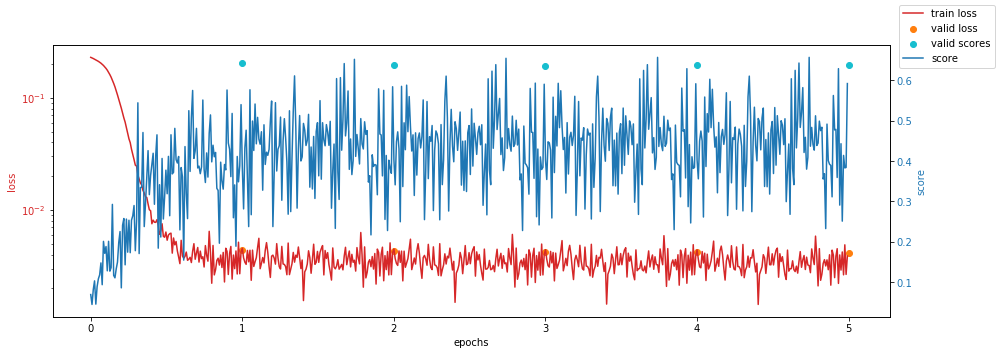

In [28]:
plot_metrics(train_losses, train_scores, valid_losses, valid_scores)

Embedding, MSE Loss, lr = 1e-6, recall at 10:

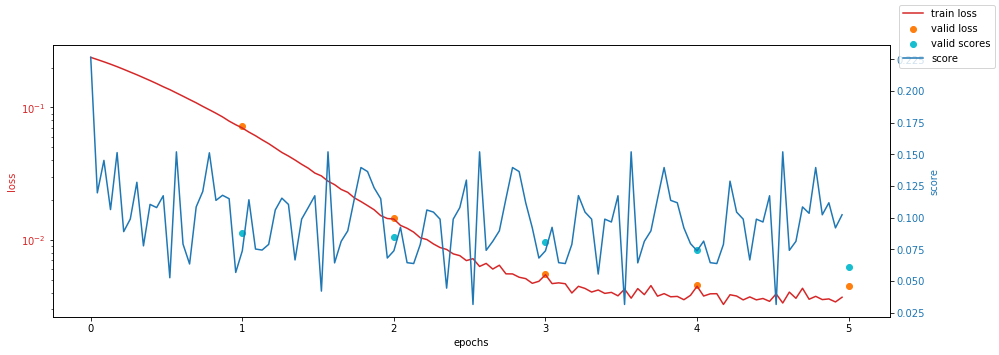

In [12]:
plot_metrics(train_losses, train_scores, valid_losses, valid_scores)

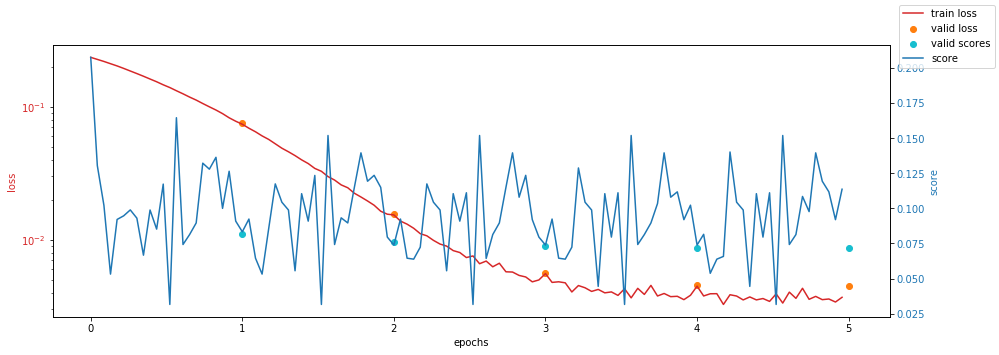

In [11]:
plot_metrics(train_losses, train_scores, valid_losses, valid_scores)

Embeddings, Cross Entropy Loss, lr = 1e-6, recall at 10:

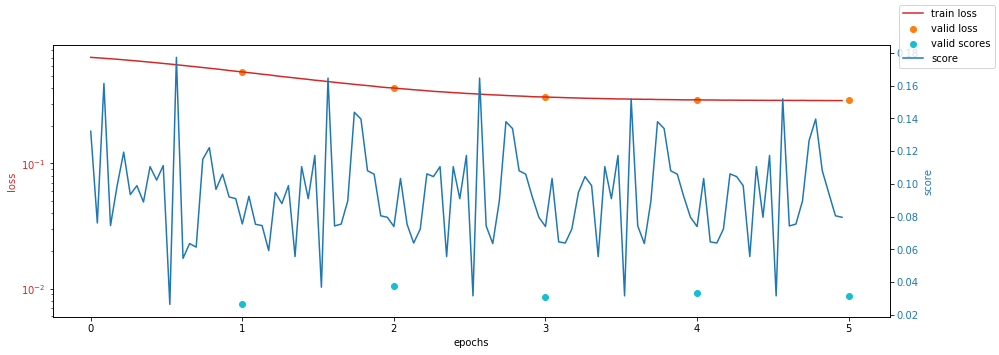

In [13]:
plot_metrics(train_losses, train_scores, valid_losses, valid_scores)

Embeddings, MSE Loss, lr = 1e-6, ap at 32:

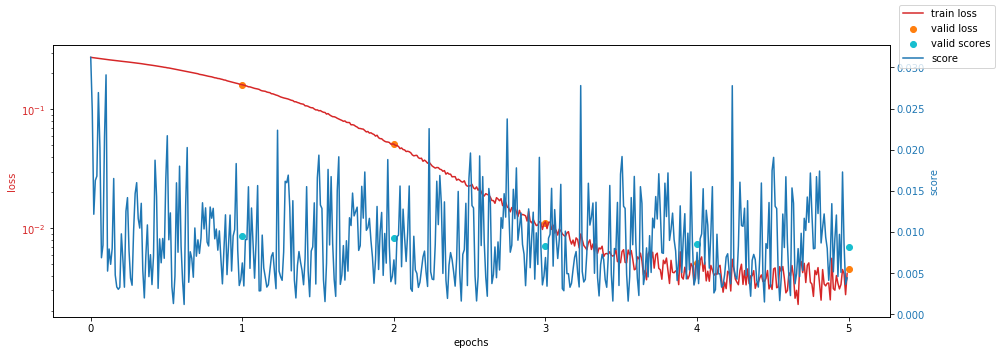

In [14]:
plot_metrics(train_losses, train_scores, valid_losses, valid_scores)

Embeddings, Cross Entropy Loss, lr = 1e-6, ap_at_32:

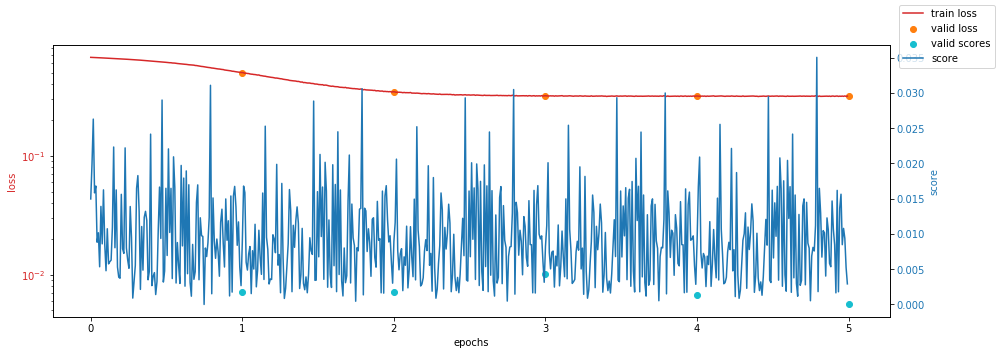

In [14]:
plot_metrics(train_losses, train_scores, valid_losses, valid_scores)